## AML Homework 4 Task 1
## UNI: hs3159 Name: Harguna Sood
## UNI: sv2609 Name: Siddhanth Vinay 

In [1]:
!pip install category_encoders

     |████████████████████████████████| 102kB 3.7MB/s 


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.pipeline import  make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder 
from category_encoders.target_encoder import TargetEncoder
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data = pd.read_csv("/content/gdrive/My Drive/winemag-data-130k-v2.csv")

#### Using data for US

In [0]:
data = data.drop(["Unnamed: 0"], axis = 1)
data = data[data["country"] == "US"].reset_index(drop=True)
data = data.drop(["country"], axis = 1)

In [6]:
data.head()

,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
1,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
2,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
3,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
4,"Slightly reduced, this wine offers a chalky, t...",NaN,87,34.0,California,Alexander Valley,Sonoma,Virginie Boone,@vboone,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini


#### Extracting year from title

In [0]:
data["title"] = data["title"].str.extract(r'(\d{4})')

#### Using taster_name instead of taster_Twitter_handle as both will roughy give the same results, but taster_twitter_handle has more null values.

In [0]:
data = data.drop(["taster_twitter_handle"], axis = 1)

In [0]:
text_feat = ["description"] # can get year from title
low_card_cat_feat = ["region_2", "taster_name"]  # one hot encoding 
high_card_cat_feat = ["designation", "province", "region_1", "winery", "variety"] # target encoding
cont_feat = ["price", "title"]
target = ["points"]

## Removing outliers 

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


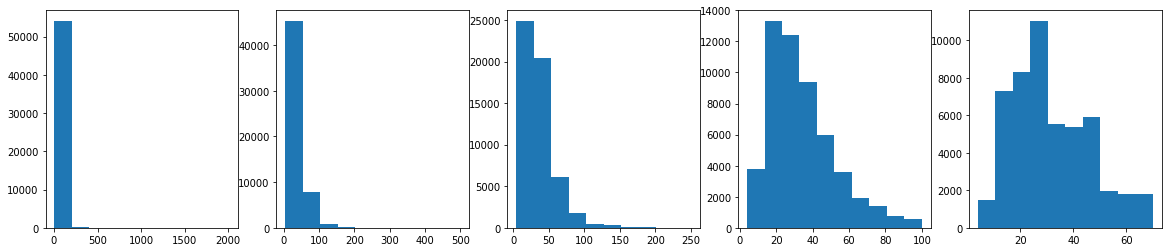

In [10]:
fig, ax = plt.subplots(1,5, figsize=(20, 4));
ax[0].hist(data["price"]);
ax[1].hist(data[data["price"]<=500]["price"]);
ax[2].hist(data[data["price"]<=250]["price"]);
ax[3].hist(data[data["price"]<=100]["price"]);
ax[4].hist(data[data["price"]<=70]["price"]);

In [11]:
data.shape

(54504, 11)

In [12]:
data = data[data["price"] <= 70]
data.shape

(50521, 11)

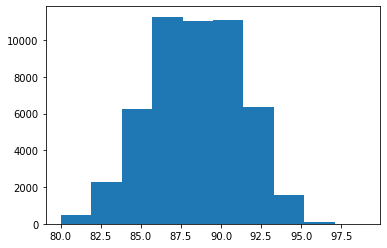

In [13]:
plt.hist(data["points"]);

## Null value treatment

In [14]:
data.isna().sum()

description        0
designation    16936
points             0
price              0
province           0
region_1         274
region_2        3885
taster_name    15416
title            904
variety            0
winery             0
dtype: int64

In [15]:
round((data.isna().sum()/data.shape[0])*100, 0)

description     0.0
designation    34.0
points          0.0
price           0.0
province        0.0
region_1        1.0
region_2        8.0
taster_name    31.0
title           2.0
variety         0.0
winery          0.0
dtype: float64

In [0]:
# by looking at percent of data missing in each column, dropping rows with null region_1 and  values
data = data[data["region_1"].notna() & data["title"].notna()]

# treating rest of missing values as a new "unknown" category
data = data.fillna("new_cat")

## Sampling and shuffling data

In [17]:
sample_data, a = tts(data, test_size=0.5, shuffle=False)
sample_data.shape

(24692, 11)

In [18]:
data_shuff = sample_data.sample(frac=1, random_state=5).reset_index(drop=True)
X = data_shuff.drop(target, axis = 1)
y = data_shuff[target]

xtrain, xtest, ytrain, ytest = tts(X, y, shuffle = False, test_size = 0.2)

xtrain_non_text = xtrain.drop(text_feat, axis = 1)

xtrain.shape

(19753, 10)

## Baseline Model

In [19]:
low_card_pipe = make_pipeline(
    OneHotEncoder(handle_unknown = "ignore"),
)

high_card_pipe = make_pipeline(
    TargetEncoder(handle_unknown = "value"),
    SimpleImputer(strategy="median"),
    StandardScaler()
)

cont_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
)

preprocess = make_column_transformer(
    (low_card_pipe, low_card_cat_feat),
    (high_card_pipe, high_card_cat_feat),
    (cont_pipe, cont_feat),
)

#pipeline
pipe = make_pipeline(preprocess, Ridge())

np.mean(cross_val_score(pipe, xtrain_non_text, ytrain, scoring = "r2", cv = 5))


0.4023095268476976

In [20]:
pipe.fit(xtrain_non_text,ytrain)
xtest_non_text = xtest.drop(text_feat, axis = 1)
pipe.score(xtest_non_text,ytest)

0.4153437886510346

## Bag of Words

In [21]:
xtrain["description"]

0        Tempting aromas like fresh-baked bread and rip...
1        Thick, rich and ripe in vanilla, the American ...
2        This barrel selection has long been Signorello...
3        The alcohol is overwhelming here in an otherwi...
4        Blended with 5% Sémillon, this crisp, tropical...
                               ...                        
19748    Exuberant and floral on the nose, this Rieslin...
19749    Sun-ripened bramble and dried herbs lend a sav...
19750    A quick sniff and you're converted to this coo...
19751    Aromas of this medium-bodied, un-oaked wine su...
19752    The dried tobacco, vanilla, green olive and co...
Name: description, Length: 19753, dtype: object

In [22]:
c_vec = CountVectorizer(token_pattern=r'\b\w+\b', stop_words="english", min_df=10)
desc = c_vec.fit_transform(xtrain["description"])
desc.shape

(19753, 3619)

In [24]:
pipe = make_pipeline(CountVectorizer(token_pattern=r'\b\w+\b', stop_words="english", min_df=20), Ridge())

np.mean(cross_val_score(pipe, xtrain["description"], ytrain, scoring = "r2", cv = 5))

0.6208830798597

## tf-idf rescaling

In [25]:
pipe = make_pipeline(CountVectorizer(token_pattern=r'\b\w+\b', stop_words="english", min_df=20),
                     TfidfTransformer(), Ridge())

np.mean(cross_val_score(pipe, xtrain["description"], ytrain, scoring = "r2", cv = 5))

0.6395496410067186

## n-grams

In [26]:
pipe = make_pipeline(CountVectorizer(token_pattern=r'\b\w+\b', stop_words="english", min_df=20, ngram_range=(1,4)),
                     TfidfTransformer(), Ridge())

np.mean(cross_val_score(pipe, xtrain["description"], ytrain, scoring = "r2", cv = 5))

0.6408489032903972

In [27]:
pipe = make_pipeline(CountVectorizer(token_pattern=r'\b\w+\b', stop_words="english", min_df=20, ngram_range=(1,3)),
                     TfidfTransformer(), Ridge())

np.mean(cross_val_score(pipe, xtrain["description"], ytrain, scoring = "r2", cv = 5))

0.6408633223281142

In [28]:
pipe = make_pipeline(CountVectorizer(token_pattern=r'\b\w+\b', stop_words="english", min_df=20, ngram_range=(1,2)),
                     TfidfTransformer(), Ridge())

np.mean(cross_val_score(pipe, xtrain["description"], ytrain, scoring = "r2", cv = 5))

0.6410622296931809

In [29]:
pipe = make_pipeline(CountVectorizer(token_pattern=r'\b\w+\b', stop_words="english", min_df=20, ngram_range=(1,2)),
                     Ridge())

np.mean(cross_val_score(pipe, xtrain["description"], ytrain, scoring = "r2", cv = 5))

0.5993858240486029

In [30]:
pipe = make_pipeline(CountVectorizer(token_pattern=r'\b\w+\b', stop_words="english", min_df=20, ngram_range=(2,2)),
                     Ridge())

np.mean(cross_val_score(pipe, xtrain["description"], ytrain, scoring = "r2", cv = 5))

0.25940112746584665

In [31]:
pipe = make_pipeline(CountVectorizer(token_pattern=r'\b\w+\b', stop_words="english", min_df=20, ngram_range=(3,3)),
                     Ridge())

np.mean(cross_val_score(pipe, xtrain["description"], ytrain, scoring = "r2", cv = 5))

0.0292381364305359

## character n-grams

In [32]:
pipe = make_pipeline(CountVectorizer(token_pattern=r'\b\w+\b', stop_words="english", min_df=20,
                                     ngram_range=(1,2), analyzer="char"),TfidfTransformer(), Ridge())

np.mean(cross_val_score(pipe, xtrain["description"], ytrain, scoring = "r2", cv = 5))

0.5422575645952726

In [33]:
pipe = make_pipeline(CountVectorizer(token_pattern=r'\b\w+\b', stop_words="english", min_df=10,
                                     ngram_range=(1,3), analyzer="char"),TfidfTransformer(), Ridge())

np.mean(cross_val_score(pipe, xtrain["description"], ytrain, scoring = "r2", cv = 5))

0.6561878461654749

In [34]:
pipe = make_pipeline(CountVectorizer(token_pattern=r'\b\w+\b', stop_words="english", min_df=30,
                                     ngram_range=(1,3), analyzer="char"),TfidfTransformer(), Ridge())

np.mean(cross_val_score(pipe, xtrain["description"], ytrain, scoring = "r2", cv = 5))

0.6542910991452722

### Finally, using count vectorizer,  character (1-3)-grams, tf-idf to tune regularization parameter

In [35]:
pipe = make_pipeline(CountVectorizer(token_pattern=r'\b\w+\b', stop_words="english", min_df=10,
                                     ngram_range=(1,3), analyzer="char"),TfidfTransformer(), Ridge(alpha=0.1))

np.mean(cross_val_score(pipe, xtrain["description"], ytrain, scoring = "r2", cv = 5))

0.648060837045632

In [36]:
pipe = make_pipeline(CountVectorizer(token_pattern=r'\b\w+\b', stop_words="english", min_df=10,
                                     ngram_range=(1,3), analyzer="char"),TfidfTransformer(), Ridge(alpha=10))

np.mean(cross_val_score(pipe, xtrain["description"], ytrain, scoring = "r2", cv = 5))

0.5773407328157109

### Final linear model (ridge): 
count vectorizer (min_df=10),  character (1-3)-grams, tf-idf with regularization=1

In [0]:
pipe = make_pipeline(CountVectorizer(token_pattern=r'\b\w+\b', stop_words="english", min_df=10,
                                     ngram_range=(1,3), analyzer="char"),TfidfTransformer(), Ridge())

In [38]:
pipe.fit(xtrain['description'],ytrain)
pipe.score(xtest['description'],ytest)

0.6571514010392104

## Text + Non-text

In [46]:
low_card_pipe = make_pipeline(
    OneHotEncoder(handle_unknown = "ignore"),
)

high_card_pipe = make_pipeline(
    TargetEncoder(handle_unknown = "value"),
    SimpleImputer(strategy="median"),
    StandardScaler()
)

cont_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
)

text_pipe = make_pipeline(
    CountVectorizer(token_pattern=r'\b\w+\b', stop_words="english", #min_df=10, max_df = 20000,
                    ngram_range=(1,3), analyzer="char"),
    TfidfTransformer()
)

preprocess = make_column_transformer(
    (low_card_pipe, low_card_cat_feat),
    (high_card_pipe, high_card_cat_feat),
    (cont_pipe, cont_feat),
    (text_pipe, "description")
)

#pipeline
pipe = make_pipeline(preprocess, Ridge())

grid_pipe = GridSearchCV(pipe,param_grid={'ridge__alpha': [0.01,0.1,1]},)
                         
grid_pipe.fit(xtrain,ytrain)





GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('onehotencoder',
                                                                                          OneHotEncoder(categories='auto',
                                                                                                        drop=None,
                 

### Hence, using a ridge regression model with alpha = 1 yields the best results after cross-validation grid search.

In [47]:
grid_pipe.best_params_

{'ridge__alpha': 1}

In [49]:
grid_pipe.score(xtest,ytest)

0.7278046214230925

## R2 on test data using the 3 models:
### Baseline: 0.415
### (1,3) grams: 0.657
### Text + Non text: 0.727

### Thus, we see that the model combining both text and non-text features performs best on the test data.